# Attention Experiment Results

In [27]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [28]:
%matplotlib inline

In [29]:
sns.set_style("whitegrid")

In [30]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-attention-lite-fix-params-and-seed',))]

# old: mpcnn-attention-lite-fix-params-and-seed

In [31]:
len(experiment_rows)

90

In [32]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if 'attention' in args:
        if args['attention'] == 'basic':
            arch = 'Attention'
        elif args['attention'] == 'idf':
            arch = 'idf-Attention'
    else:
        arch = 'MP-CNN Lite'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [33]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [34]:
trecqa['arch'].unique()

array(['MP-CNN Lite', 'Attention', 'idf-Attention'], dtype=object)

In [35]:
archs = ['MP-CNN Lite', 'Attention', 'idf-Attention']
def compare_change_to_baseline(df, metric):
    changes = {'MP-CNN Lite': 'baseline'}
    config_ids = df['seed'].unique()
    for arch in archs:
        if arch == 'MP-CNN Lite':
            continue
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN Lite')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')
        diff = np.median(diffs)
        changes[arch] = f'+{diff:.4f}' if diff > 0 else f'{diff:.4f}'
    
    return changes

## TrecQA

In [36]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [37]:
trec_map_intervals = {}
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN Lite: (0.7487, 0.7781)
Attention: (0.7641, 0.7867)
idf-Attention: (0.7716, 0.7869)


In [38]:
trec_mrr_intervals = {}
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    trec_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN Lite: (0.8165, 0.8475)
Attention: (0.8261, 0.8494)
idf-Attention: (0.8242, 0.8545)


In [39]:
trec_map_delta = compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Attention
Median of MAP change compared with single baseline: 0.0169
Mean of MAP change compared with single baseline: 0.0120
Architecture: idf-Attention
Median of MAP change compared with single baseline: 0.0141
Mean of MAP change compared with single baseline: 0.0159


In [40]:
trec_mrr_delta = compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Attention
Median of MRR change compared with single baseline: 0.0032
Mean of MRR change compared with single baseline: 0.0058
Architecture: idf-Attention
Median of MRR change compared with single baseline: 0.0024
Mean of MRR change compared with single baseline: 0.0073


## WikiQA

In [41]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [42]:
wikiqa_map_intervals = {}
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_map_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN Lite: (0.6730, 0.6879)
Attention: (0.6809, 0.6924)
idf-Attention: (0.6833, 0.6977)


In [43]:
wikiqa_mrr_intervals = {}
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    wikiqa_mrr_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN Lite: (0.6851, 0.7010)
Attention: (0.6963, 0.7070)
idf-Attention: (0.6968, 0.7124)


In [44]:
wikiqa_map_delta = compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Attention
Median of MAP change compared with single baseline: 0.0048
Mean of MAP change compared with single baseline: 0.0062
Architecture: idf-Attention
Median of MAP change compared with single baseline: 0.0109
Mean of MAP change compared with single baseline: 0.0100


In [45]:
wikiqa_mrr_delta = compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Attention
Median of MRR change compared with single baseline: 0.0071
Mean of MRR change compared with single baseline: 0.0086
Architecture: idf-Attention
Median of MRR change compared with single baseline: 0.0135
Mean of MRR change compared with single baseline: 0.0116


## SICK

In [46]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [47]:
sick_pearson_intervals = {}
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_pearson_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN Lite: (0.8598, 0.8649)
Attention: (0.8617, 0.8663)
idf-Attention: (0.8622, 0.8670)


In [48]:
sick_spearman_intervals = {}
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')
    sick_spearman_intervals[arch] = (f'{ci[0]:.4f}', f'{ci[1]:.4f}')

MP-CNN Lite: (0.7953, 0.8015)
Attention: (0.7981, 0.8037)
idf-Attention: (0.7999, 0.8047)


In [49]:
sick_pearson_delta = compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Attention
Median of pearson change compared with single baseline: 0.0013
Mean of pearson change compared with single baseline: 0.0016
Architecture: idf-Attention
Median of pearson change compared with single baseline: 0.0022
Mean of pearson change compared with single baseline: 0.0022


In [50]:
sick_spearman_delta = compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Attention
Median of spearman change compared with single baseline: 0.0023
Mean of spearman change compared with single baseline: 0.0025
Architecture: idf-Attention
Median of spearman change compared with single baseline: 0.0032
Mean of spearman change compared with single baseline: 0.0039


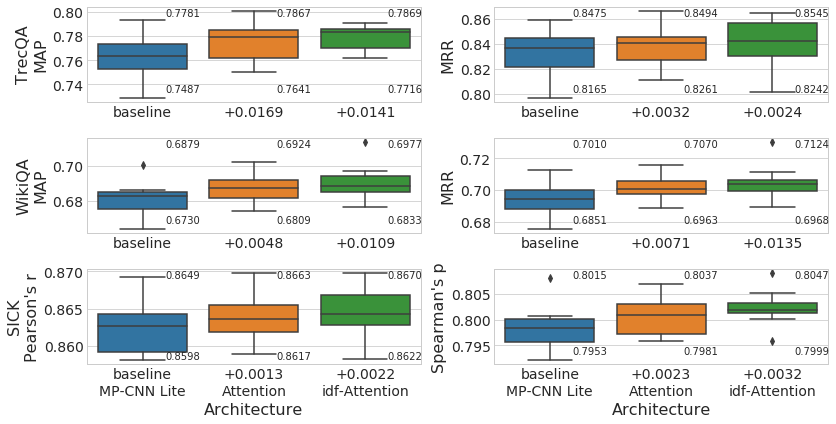

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 6)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.boxplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('TrecQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_map_intervals[a][1])

ax = plt.subplot(322)
sns.boxplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([trec_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), trec_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), trec_mrr_intervals[a][1])

ax = plt.subplot(323)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('WikiQA\nMAP', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_map_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_map_intervals[a][1])

ax = plt.subplot(324)
sns.boxplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.yticks(fontsize=tick_size)
plt.xlabel('', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([wikiqa_mrr_delta[a] for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), wikiqa_mrr_intervals[a][1])

ax = plt.subplot(325)
sns.boxplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("SICK\nPearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_pearson_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.05*(ylim[1] - ylim[0]), sick_pearson_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_pearson_intervals[a][1])

ax = plt.subplot(326)
sns.boxplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
ax.xaxis.set_ticklabels([sick_spearman_delta[a] + '\n' + a for a in archs])
ylim = ax.get_ylim()
for i, a in enumerate(archs):
    ax.text(0.2+i*1, ylim[0] + 0.1*(ylim[1] - ylim[0]), sick_spearman_intervals[a][0])
    ax.text(0.2+i*1, ylim[0] + 0.9*(ylim[1] - ylim[0]), sick_spearman_intervals[a][1])
plt.tight_layout()
# plt.subplots_adjust(top=0.8, hspace=0.2)
plt.savefig('attention_violin.pdf')